In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Initialization

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import lightgbm as lgb
from tqdm.notebook import tqdm
tqdm.pandas()

#!pip install Wordbatch
#from wordbatch.models import FTRL, FM_FTRL  # https://github.com/anttttti/Wordbatch
import xgboost  # Version 0.90
# Scikit-learn version 0.22.2.post1
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:

import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/PricePred/Dataset/train.tsv', sep='\t')
# Price range should be 5 - 2000, https://www.mercari.com/us/help_center/article/69
train_df = train_df[train_df['price']>=5]  # Removing the prodicts with prices less than 5
train_df = train_df[train_df['price']<=2000]  # Removing the prodicts with prices more than 2000
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


#### Adding log price column

<Axes: xlabel='log_price', ylabel='Density'>

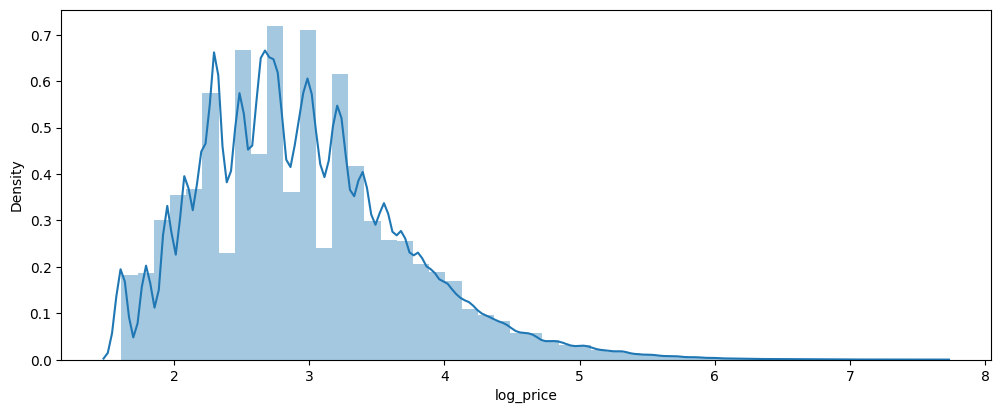

In [4]:
from scipy import stats

train_df['log_price'] = np.log(train_df['price'].values)

plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(train_df['log_price'])

#### Train Test Split

In [5]:
X = train_df.drop(['train_id','log_price','price'], axis=1)
y = train_df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
#del X, y, train_df

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
def evaluate_model(model, X_data, y_act):
    y_pred = model.predict(X_data)

    act_prices = np.round(np.exp(y_act), 2)
    pred_prices = np.round(np.exp(y_pred), 2)

    rms = np.sqrt(mean_squared_log_error(act_prices.values, pred_prices))
    return rms

def do_inference(model, X_te):
  y_pred = model.predict(X_te)
  pred_prices = np.round(np.exp(y_pred), 2)

  return pred_prices

(1374475, 6)
(1374475,)
(72341, 6)
(72341,)


### Feature Engineering

#### Filling missing values

In [7]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

#### Text Pre-processing

In [8]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess_descriptive_text_column(sentance):
    """
    Description:
    This function will process the text data.
    This function will perform decontracting words, removing stop words, removing special characters and then apply stemming on the words in the sentence.

    Input: original sentence
    Output: processed sentence
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    sent = decontract_text(sentance)
    sent = sent.replace('\r', ' ')
    sent = sent.replace('\n', ' ')
    sent = sent.replace('\"', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    sent = sent.lower()
    return sent


#### Fill Missing Brand Names

In [9]:
import pickle
with open('/content/drive/MyDrive/PricePred/SavedVectors/brands_list.pkl', 'rb') as f:
    existing_brands = pickle.load(f)

with open('/content/drive/MyDrive/PricePred/SavedVectors/brand_names_categories_dict.pkl', 'rb') as f:
    brand_names_categories = pickle.load(f)

In [10]:
def brand_guesser(row):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section.
    We want our guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product.
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe row with missing brand names
    Output: dataframe row with filled brand names
    """
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    brand, name, cn = row
    brand = brand.lower()
    if brand=='unk_brand':
        for brand in existing_brands:
            if brand in name.lower() and cn in brand_names_categories[brand]:
                return brand

    return brand

#### Split Categories


In [11]:

def split_text(text):
    if text=='unk_cat':
        return ["No Label", "No Label", "No Label"]
    return text.split("/")

def split_categories(df):
    """
    Desription:
    This function separates the categories into its three parts.
    Main category, Sub-category 1 and Sub-category 2
    Then it will remove the original category_name field.

    Input: Dataframe having category_name field
    Output: Dataframe with splitted categories
    """
    df['general_cat'], df['subcat_1'], df['subcat_2'] = zip(*df['category_name'].apply(lambda x: split_text(x)))
    df = df.drop('category_name', axis=1)
    return df

#### Adding Item Description len and Item Name len

In [12]:
from sklearn.preprocessing import StandardScaler
def get_len_feature(col_series, scaler_text_len=None):
    """
    Description:
    This funciton will calculate the word count of the text and standardize it.

    Input: Series, fitted scaler[optional; used during inference]
    Output: standardized text length for each product and object of the fitted scaler
    """
    text_len = col_series.apply(lambda x: len(x.split()))
    if scaler_text_len==None:
        scaler_text_len = StandardScaler()
        scaler_text_len.fit(text_len.values.reshape(-1, 1))
    text_len = scaler_text_len.transform(text_len.values.reshape(-1, 1))
    return text_len, scaler_text_len

#### Add is_expensive

In [13]:
def get_is_expensive_feature(df):
    """
    Description:
    This funciton will generate a feature which will tell if the brand is expensive or not.

    Input: Dataframe
    Output: Sparse is_expensive data
    """
    with open('/content/drive/MyDrive/PricePred/SavedVectors/expensive_brands.pkl', 'rb') as f:
        expensive_brands = pickle.load(f)

    df['is_expensive'] = df['brand_name'].apply(lambda x: 1 if x in expensive_brands else 0)
    return df

#### Feature Engineering pipeline

In [14]:
def feature_pipeline(X_data, scaler_name_len=None, scaler_desc_len=None):
    """
    Description: This function will do all the feature engineering on the input X_data,
                and create a final data, ready for training.

    Input: Original input dataframe,
                    scalers [optional: used during inference]
    Output: Featurized data
    """
    print()
    print("Filling missing values...")
    X_data = fill_missing_values(X_data)

    print("pre-processing text data...")
    X_data['item_description'] = X_data['item_description'].progress_apply(preprocess_descriptive_text_column) ### temp step ###
    X_data['name'] = X_data['name'].progress_apply(preprocess_descriptive_text_column)                         ### temp step ###
    X_data['brand_name'] = X_data['brand_name'].progress_apply(lambda x: str(x).lower())

    print("Guessing the missing brands...")
    X_data['brand_name'] = X_data[['brand_name','name', 'category_name']].progress_apply(brand_guesser, axis = 1)

    print("Splitting categories...")
    X_data = split_categories(X_data)

    print('Getting word lengths')
    X_data['name_len'], scaler_name_len =  get_len_feature(X_data['name'], scaler_name_len)
    X_data['desc_len'], scaler_desc_len =  get_len_feature(X_data['item_description'], scaler_desc_len)

    print("Getting is_expensive brand feature...")
    X_data = get_is_expensive_feature(X_data)

    print("Done!!!\n---------------------------\n")
    return X_data, scaler_name_len, scaler_desc_len


### LSTM MODEL

In [15]:
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU

In [27]:
def text_embeddings(text_train, text_test):
    """
    This function does the tokenizing, padding, creating vocab and creating the embedding matrix for text data
    """
    # Word Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_train)
    encoded_docs_train = tokenizer.texts_to_sequences(text_train)

    encoded_docs_test = tokenizer.texts_to_sequences(text_test)

    # Getting the 'max len' of doc among the text_train
    len_docs = []
    for doc in text_train:
        splitted_doc = doc.split()
        len_docs.append(len(splitted_doc))
    max_len_doc = max(len_docs)
    #print('max doc len=',max_len_doc) # in terms of words

    text_train_padded = pad_sequences(encoded_docs_train, maxlen=max_len_doc, padding='post')
    text_test_padded = pad_sequences(encoded_docs_test, maxlen=max_len_doc, padding='post')

    vocab_size = len(tokenizer.word_index) + 1
    #print(vocab_size)

    embeddings_index = dict()
    with open('/content/drive/MyDrive/PricePred/Embeddings/glove.6B.200d.txt') as f:
        for line in f:
            w_coef = line.split()
            word = w_coef[0]
            coefs = asarray(w_coef[1:], dtype='float32')
            embeddings_index[word]=coefs

    embedding_matrix = zeros((vocab_size, 200))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, vocab_size, max_len_doc, text_train_padded, text_test_padded


In [17]:
# THIS CODE IS USED TO OVERCOME THE UNKNOWN CATEGORICAL VALUES ENCOUNTERED IN THE TEST DATA, WHEN USING Sklearn's LabelEncoder
# We basically add a 'Unknown' category when fitting, to accomodate all the unseen/unknown values in test data
# https://stackoverflow.com/a/56876351/7697658

from sklearn.preprocessing import LabelEncoder
import numpy as np

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [18]:
# Why you should not use One Hot Encoding for this,
# https://stackoverflow.com/a/51184399/7697658

# Embedding categorical data,
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
def categorical_embeddings(cat_train, cat_test):
    """
    This function will do Label encoding of the categorical feature.
    """
    vocab_size = len(cat_train.unique())+1
    le = LabelEncoderExt()
    le.fit(cat_train.values)
    encoded_train = le.transform(cat_train.values)
    encoded_test = le.transform(cat_test.values)

    return vocab_size, encoded_train, encoded_test

In [19]:
def numeric_standardizing(X_train_numeric, X_test_numeric):
    """
    This function will normalize the numeric feature.
    """
    scaler = Normalizer()
    scaler.fit(X_train_numeric.values.reshape(1,-1))

    X_train_price_scaled = scaler.transform(X_train_numeric.values.reshape(1,-1))
    X_test_price_scaled = scaler.transform(X_test_numeric.values.reshape(1,-1))
    return X_train_price_scaled.flatten(), X_test_price_scaled.flatten()

def text_model_pipeline(input_len, vocab_size, embedding_matrix, layer_name):
    """
    This function will create a sub-model of the text data using embedding layer and GRU.
    """
    input_layer = Input(shape=input_len, name=layer_name+'_input')
    e_layer = Embedding(input_dim=vocab_size, output_dim=200, weights=[embedding_matrix], input_length=input_len, trainable=True,
                        name=layer_name+'_embedding')(input_layer)
    #e_layer = Embedding(input_dim=vocab_size, output_dim=80, trainable=True, name=layer_name+'_embedding')(input_layer)
    lstm = GRU(units=128, name=layer_name+'_lstm')(e_layer)
    #flat = Flatten()(lstm)
    #out = flat
    out = lstm
    model = Model(inputs=input_layer ,outputs=out)
    return model

def categorical_model_pipeline(input_len, vocab_size, layer_name):   # Here vocab_size will be the number of unique values in the column
    """
    This function will create a sub-model of the categorical data. It will use embedding layer to embedd the categories.
    """
    input_layer = Input(shape=input_len, name=layer_name+'_input')
    e_layer  = Embedding(input_dim=vocab_size, output_dim=32, trainable=True, name=layer_name+'_embedding')(input_layer)
    flat = Flatten()(e_layer)
    out = flat
    model = Model(inputs=input_layer ,outputs=out)
    return model

def numeric_model_pipeline(input_len, layer_name):
    """
    This function will create a sub-model of the numeric data using a single dense layer.
    """
    input_layer = Input(shape=input_len, name=layer_name+'_input')
    dense = Dense(units=32,activation='relu', name=layer_name+'_dense')(input_layer)
    out = dense
    model = Model(inputs=input_layer ,outputs=out)
    return model

In [20]:
# Featurizing the input data.
X_train, scaler_name_len, scaler_desc_len = feature_pipeline(X_train, scaler_name_len=None, scaler_desc_len=None)
X_test, _, _ = feature_pipeline(X_test, scaler_name_len, scaler_desc_len)


Filling missing values...
pre-processing text data...


  0%|          | 0/1374475 [00:00<?, ?it/s]

  0%|          | 0/1374475 [00:00<?, ?it/s]

  0%|          | 0/1374475 [00:00<?, ?it/s]

Guessing the missing brands...


  0%|          | 0/1374475 [00:00<?, ?it/s]

Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Done!!!
---------------------------


Filling missing values...
pre-processing text data...


  0%|          | 0/72341 [00:00<?, ?it/s]

  0%|          | 0/72341 [00:00<?, ?it/s]

  0%|          | 0/72341 [00:00<?, ?it/s]

Guessing the missing brands...


  0%|          | 0/72341 [00:00<?, ?it/s]

Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Done!!!
---------------------------



In [21]:
# # https://stackoverflow.com/a/8980156/7697658
#scipy.sparse.save_npz("/content/drive/MyDrive/PricePred/Dataset/x_train_OHE_wo_binary_brand.npz", X_train)
#scipy.sparse.save_npz("/content/drive/MyDrive/PricePred/Dataset/x_test_OHE_wo_binary_brand.npz", X_test)

In [22]:
# CREATE MODEL-1

# Using multiple (mixed) input data to the model
# https://stackoverflow.com/a/55234203/7697658
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

# Using multiple input and output data to the model. Watch after 4:12 minutes
# https://www.coursera.org/lecture/customising-models-tensorflow2/multiple-inputs-and-outputs-XVZYB

tf.keras.backend.clear_session()

def create_model_1(X_train, X_test):
    """
    This function creates the model structure.
    """
    ####################### Text data ######################
    desc_embedding_matrix, desc_vocab_size, desc_max_len_doc, desc_text_train_padded, desc_text_test_padded = text_embeddings(X_train['item_description'].apply(str), X_test['item_description'].apply(str))
    name_embedding_matrix, name_vocab_size, name_max_len_doc, name_text_train_padded, name_text_test_padded = text_embeddings(X_train['name'].apply(str), X_test['name'].apply(str))

    desc_flat_model = text_model_pipeline(desc_max_len_doc, desc_vocab_size, desc_embedding_matrix, 'description')
    name_flat_model = text_model_pipeline(name_max_len_doc, name_vocab_size, name_embedding_matrix, 'name')
    ########################################################


    ################### Categorical data ###################
    bn_vocab_size, bn_encoded_train, bn_encoded_test = categorical_embeddings(X_train['brand_name'], X_test['brand_name'])
    gc_vocab_size, gc_encoded_train, gc_encoded_test = categorical_embeddings(X_train['general_cat'], X_test['general_cat'])
    sc1_vocab_size, sc1_encoded_train, sc1_encoded_test = categorical_embeddings(X_train['subcat_1'], X_test['subcat_1'])
    sc2_vocab_size, sc2_encoded_train, sc2_encoded_test = categorical_embeddings(X_train['subcat_2'], X_test['subcat_2'])
    ic_vocab_size, ic_encoded_train, ic_encoded_test = categorical_embeddings(X_train['item_condition_id'], X_test['item_condition_id'])
    sh_vocab_size, sh_encoded_train, sh_encoded_test = categorical_embeddings(X_train['shipping'], X_test['shipping'])
    is_ex_vocab_size, is_ex_encoded_train, is_ex_encoded_test = categorical_embeddings(X_train['is_expensive'], X_test['is_expensive'])

    bn_flat_model = categorical_model_pipeline(1, bn_vocab_size, 'bn')
    gc_flat_model = categorical_model_pipeline(1, gc_vocab_size, 'cn')
    sc1_flat_model = categorical_model_pipeline(1, sc1_vocab_size, 'sc1')
    sc2_flat_model = categorical_model_pipeline(1, sc2_vocab_size, 'sc2')
    ic_flat_model = categorical_model_pipeline(1, ic_vocab_size, 'ic')
    sh_flat_model = categorical_model_pipeline(1, sh_vocab_size, 'sh')
    is_ex_flat_model = categorical_model_pipeline(1, is_ex_vocab_size, 'is_ex')
    #########################################################


    ################### Numeric data ###################
    numeric_train_input = pd.concat((X_train['desc_len'], X_train['name_len']), axis=1).to_numpy()
    numeric_test_input = pd.concat((X_test['desc_len'], X_test['name_len']), axis=1).to_numpy()

    numeric_model = numeric_model_pipeline(numeric_train_input.shape[1], 'numeric')
    ####################################################


    ############### Concatenating layers ###############
    combined_layers = [desc_flat_model.output, name_flat_model.output,
                       bn_flat_model.output, gc_flat_model.output, sc1_flat_model.output, sc2_flat_model.output, ic_flat_model.output, \
                       sh_flat_model.output, is_ex_flat_model.output, numeric_model.output]
    concatenate_layer = Concatenate()(combined_layers)
    ####################################################


    dense = Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(concatenate_layer)
    for _ in range(3):
        #dense = BatchNormalization()(dense)
        dense = Dropout(0.25)(dense)
        dense = Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense)

    out = Dense(units=1, activation='linear', name='Output')(dense)

    model = Model(inputs=[desc_flat_model.input, name_flat_model.input,
                       bn_flat_model.input, gc_flat_model.input, sc1_flat_model.input, sc2_flat_model.input, ic_flat_model.input, \
                       sh_flat_model.input, is_ex_flat_model.input, numeric_model.input], \
                  outputs=out)


    X_train_inputs = [desc_text_train_padded,name_text_train_padded,bn_encoded_train,gc_encoded_train, sc1_encoded_train, sc2_encoded_train, ic_encoded_train,\
                      sh_encoded_train,is_ex_encoded_train, numeric_train_input]
    X_test_inputs = [desc_text_test_padded,name_text_test_padded,bn_encoded_test,gc_encoded_test,sc1_encoded_test,sc2_encoded_test, ic_encoded_test,\
                     sh_encoded_test,is_ex_encoded_test,numeric_test_input]
    return model, X_train_inputs, X_test_inputs


In [28]:
model_1, X_train_inputs, X_test_inputs = create_model_1(X_train, X_test)
model_1.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 description_input (InputLa  [(None, 251)]                0         []                            
 yer)                                                                                             
                                                                                                  
 name_input (InputLayer)     [(None, 13)]                 0         []                            
                                                                                                  
 bn_input (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 cn_input (InputLayer)       [(None, 1)]                  0         []                     

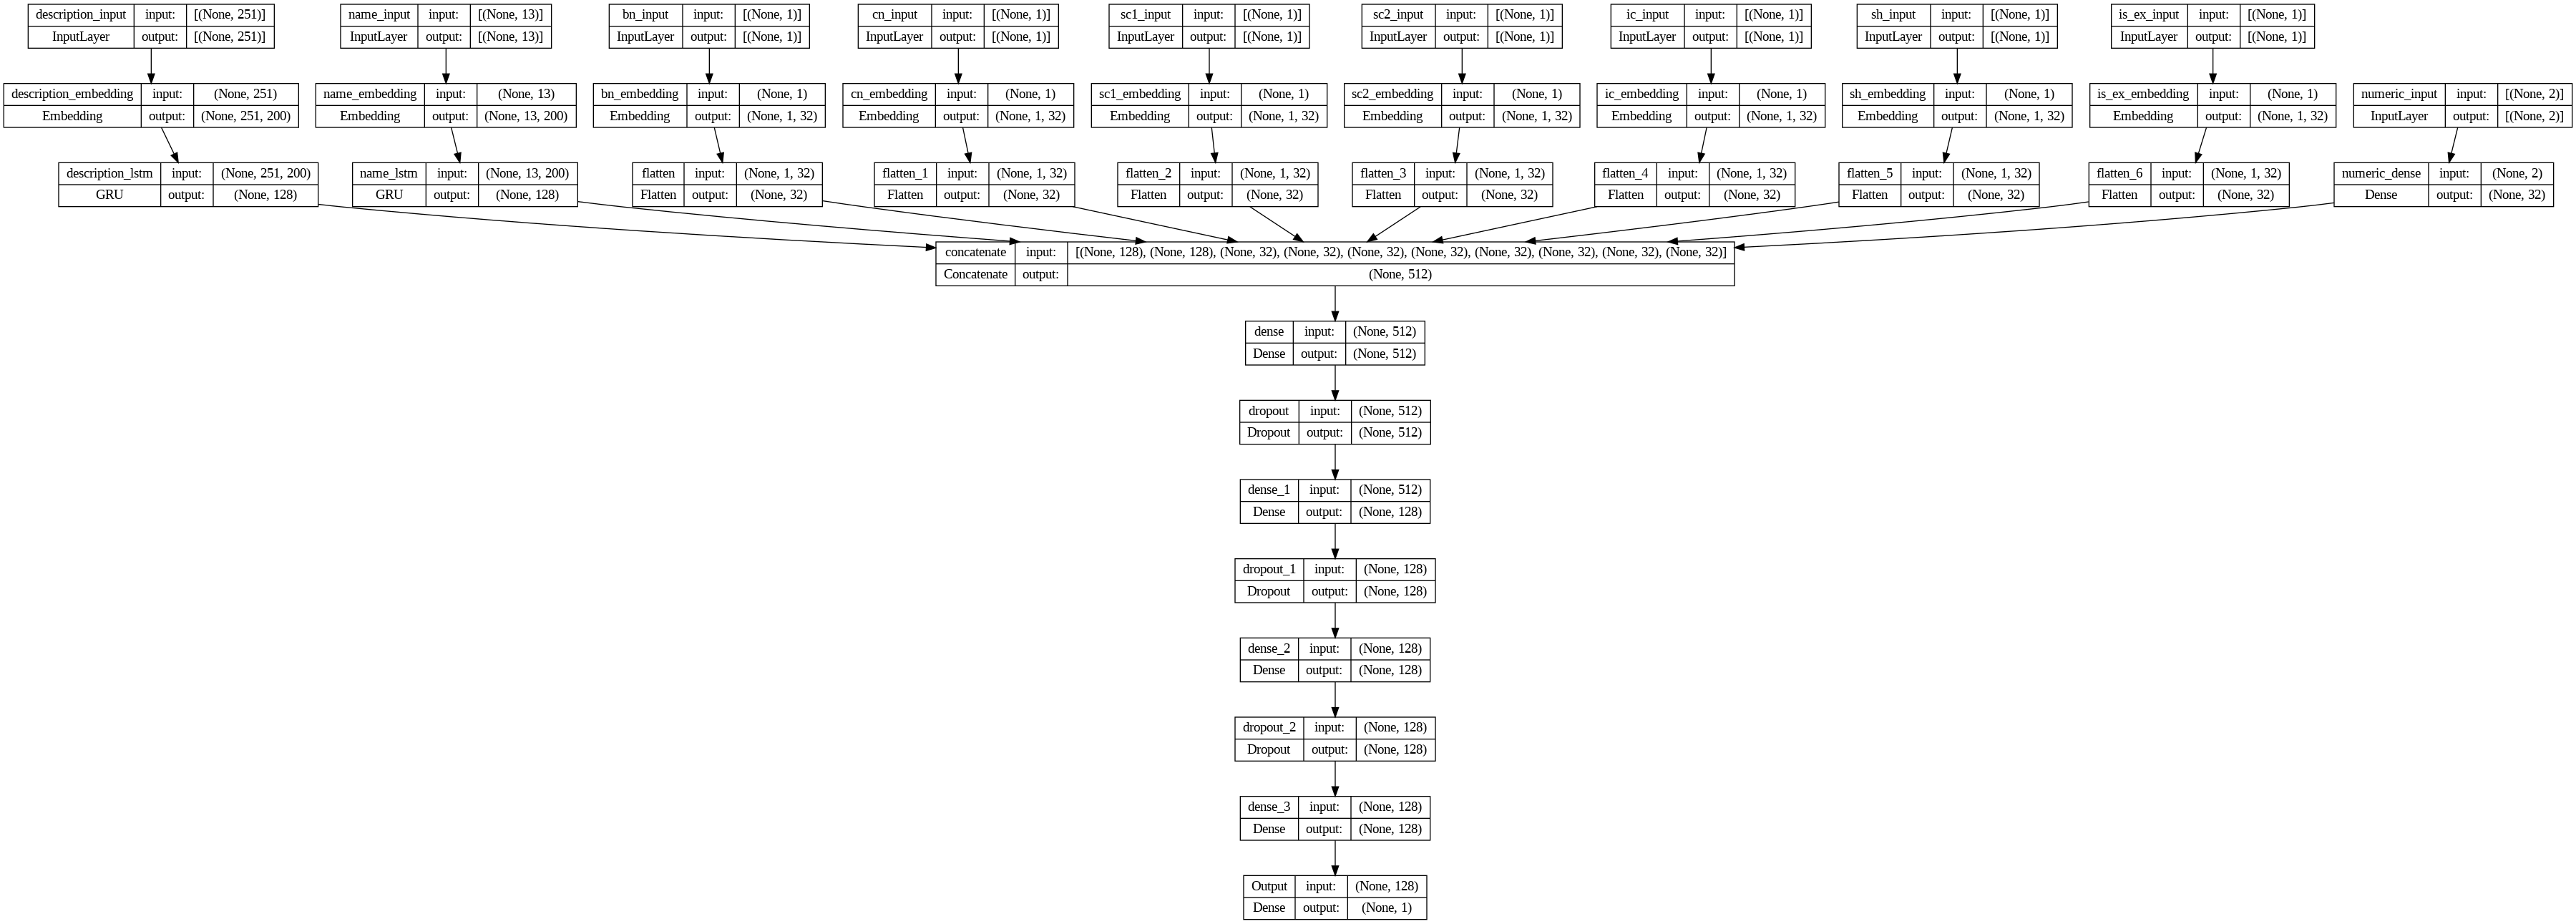

In [29]:
tf.keras.utils.plot_model(model=model_1, to_file='model_1_plot.png', show_shapes=True)

In [31]:
# For more info on ModelCheckpoint, refer https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from tensorflow.keras.callbacks import ModelCheckpoint
model_path = "/content/drive/MyDrive/PricePred/Model_MLP_Checkpoints/BEST_MODEL_2.hdfs"
checkpoint_best = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='min')

In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# https://stackoverflow.com/a/42963385/7697658
lrschedule_1 = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.70, mode='min')

In [33]:
# For more info on EarlyStoppingdelCheckpoint, refer https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

In [34]:
EPOCHS = 50
BATCH_SIZE = 512
adam = Adam(learning_rate=0.0003)
model_1.compile(optimizer=adam, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_1_hist = model_1.fit(x=X_train_inputs, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, validation_data=(X_test_inputs, y_test),
                           callbacks=[checkpoint_best, lrschedule_1, earlystop])

Epoch 1/50
2685/2685 [==============================] - ETA: 0s - loss: 0.5905 - root_mean_squared_error: 0.6293
Epoch 1: val_loss improved from inf to 0.40025, saving model to /content/drive/MyDrive/PricePred/Model_MLP_Checkpoints/BEST_MODEL_2.hdfs
2685/2685 [==============================] - 328s 118ms/step - loss: 0.5905 - root_mean_squared_error: 0.6293 - val_loss: 0.4002 - val_root_mean_squared_error: 0.5597 - lr: 3.0000e-04
Epoch 2/50
2685/2685 [==============================] - ETA: 0s - loss: 0.3097 - root_mean_squared_error: 0.5101
Epoch 2: val_loss improved from 0.40025 to 0.28146, saving model to /content/drive/MyDrive/PricePred/Model_MLP_Checkpoints/BEST_MODEL_2.hdfs
2685/2685 [==============================] - 210s 78ms/step - loss: 0.3097 - root_mean_squared_error: 0.5101 - val_loss: 0.2815 - val_root_mean_squared_error: 0.5070 - lr: 3.0000e-04
Epoch 3/50
2685/2685 [==============================] - ETA: 0s - loss: 0.2574 - root_mean_squared_error: 0.4924
Epoch 3: val_los